# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [39]:
!pip install wordcloud -q

Подключение библиотек 

In [80]:
import pandas as pd
import re
import nltk
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

tqdm.pandas()

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as stpwrds
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from wordcloud import WordCloud

Загрузка необходимых ресурсов для дальнейшей работы

In [76]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [41]:
nltk.download('punkt')
nltk.download('wordnet')
#nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Глобальные переменные

In [42]:
lemmatizer=WordNetLemmatizer()
RANDOM_STATE=42
stopwords_set = set(stpwrds.words('english'))

Загрузка данных

In [43]:
try:
    data=pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
except FileNotFoundError:
    data=pd.read_csv('toxic_comments.csv', index_col=[0])

Вывод датафрейма

In [44]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Информация о датафрейме

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Гистограмма классов

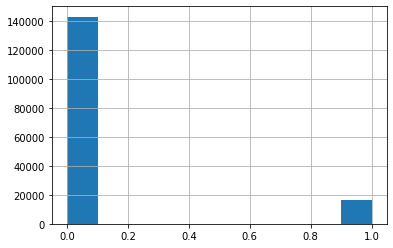

In [46]:
data['toxic'].hist();

На всякий случай просмотрим дубликаты в данных

In [47]:
data.duplicated().sum()

0

Для очистки данных от неявных дубликатов и для уменьшения словаря приведем текст в нижний регистр

In [48]:
data['text']=data['text'].str.lower()
data.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


Функция очистки текста

In [49]:
def clear_text(text):
    broom = re.sub(r'[^a-z ]', ' ', text)
    broom = ' '.join(broom.split())
    return broom

Очистка теста

In [56]:
data['text']=data['text'].progress_apply(clear_text)
data['text'].head()

  0%|          | 0/159292 [00:00<?, ?it/s]

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

Функция для лемматизации

In [81]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)

In [82]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    lemmatized_text = " ".join(lemmatized_words)
    return lemmatized_text

Лемматизация текстов

In [83]:
data['text']=data['text'].progress_apply(lemmatize)
data['text'].head()

  0%|          | 0/159292 [00:00<?, ?it/s]

0    explanation why the edits make under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not try to edit war it s ju...
3    more i can t make any real suggestion on impro...
4    you sir be my hero any chance you remember wha...
Name: text, dtype: object

На всякий случай посмотрим дубликаты после лемматизации

In [84]:
data.duplicated().sum()

1311

In [85]:
data[data.duplicated()].sort_values('text').tail(10)

,text,toxic
156806,you suck,1
150510,you suck duck butt that s right i m talkin to ...,1
40899,you well fuck off ruddy shit fuck,1
67718,your request to be unblocked ha be grant for t...,0
69871,your request to be unblocked ha be grant for t...,0
122705,your request to be unblocked ha be grant for t...,0
24622,your request to be unblocked ha be grant for t...,0
144435,your request to be unblocked ha be grant for t...,0
131665,your stalker friend be back the hostile user y...,0
94518,zionist jew please stop spreadin your lie bias...,1


Дубликаты обнаружены. Устраним их. И выведем информацию о данных после данного процесса

In [86]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157981 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    157981 non-null  object
 1   toxic   157981 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


<b>Промежуточный вывод:</b>

Выполнены следующие шаги:
- Подключение библиотек.
- Загрузка необходимых ресурсов.
- Загрузка данных.
- Создание функции очистки текста.
- Создание функции для лемматизации.
- Обнаружение и устранение дубликатов.

## Обучение

Проведем обучение модели на:
- Логистическая регрессия (Logistic Regression)
- Метод опорных векторов (SVM)
- Случайный лес (Random Forest)

Разделим данные на обучающую и тестовую выборку

In [87]:
train, test = train_test_split(data, test_size=0.3, random_state=RANDOM_STATE, stratify=data['toxic'])

In [88]:
corpus_train = train['text'].values
corpus_test = test['text'].values

In [89]:
target_train = train['toxic']
target_test = test['toxic']

In [90]:
stopwords_list = list(stopwords_set)

Выполним преобразование данных в матрицу TF-IDF

In [91]:
count_tf_idf = TfidfVectorizer(min_df=2, stop_words=stopwords_list) 
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

Обучение моделей LogisticRegression, LinearSVC, RandomForestClassifier с гиперпараметрами

In [92]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'saga']
        }
    },
    'LinearSVC': {
        'model': LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=10000),
        'params': {
            'C': [0.1, 1, 10]
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'n_estimators': [10, 25, 50],
            'max_depth': [5, 10, 20]
        }
    }
}

In [93]:
def find_best_params(model_name, model, params, X_train, y_train):
    f1_scorer = make_scorer(f1_score)
    grid_search = GridSearchCV(model, params, cv=5, scoring=f1_scorer, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f'Лучший параметр для модели {model_name}: {grid_search.best_params_}')
    print(f'Лучший результат F1 {model_name}: {grid_search.best_score_:.4f}')
    return grid_search.best_estimator_

In [94]:
best_models = {}
for model_name, model_info in models.items():
    best_model = find_best_params(model_name, model_info['model'], model_info['params'], tf_idf_train, target_train)
    best_models[model_name] = best_model

Лучший параметр для модели LogisticRegression: {'C': 10, 'solver': 'saga'}
Лучший результат F1 LogisticRegression: 0.7633
Лучший параметр для модели LinearSVC: {'C': 1}
Лучший результат F1 LinearSVC: 0.7656
Лучший параметр для модели RandomForestClassifier: {'max_depth': 20, 'n_estimators': 10}
Лучший результат F1 RandomForestClassifier: 0.0195


Логистическая регрессия показала себя хорошо, показатель F1 превысил порог нормы в 0.75.

Метод опорных векторов (SVM) продемонстрировал хорошие результаты, превысив порог F1-score в 0.75.

Случайный лес продемонстрировал самые низкие результаты: низкий показатель F1 и значительное время обучения.

Для проверки реализуем метод LinearSVC т. к. он показал наилучшее значение на тестовых данных

In [97]:
best_params_lsvc = best_models['LinearSVC'].get_params()

model_lsvc = LinearSVC(**best_params_lsvc)

In [98]:
%%time
model_lsvc.fit(tf_idf_train, target_train)

y_pred_lsvc = model_lsvc.predict(tf_idf_test)

f1_lsvc_test = f1_score(target_test, y_pred_lsvc)
print(f'Оценка F1 LinearSVC на тестовой выборке: {f1_lsvc_test:.4f}')

Оценка F1 LinearSVC на тестовой выборке: 0.7769
CPU times: user 6.71 s, sys: 6.57 s, total: 13.3 s
Wall time: 13.3 s


<b>Промежуточный вывод:</b>
- Логистическая регрессия: Показала хороший результат с F1-score 0.7633, время выполнения — 5.17 секунд.
- LinearSVC: Продемонстрировал лучший результат с F1-score 0.7656, время выполнения — 5.87 секунд.
- RandomForest: Имеет низкий F1-score 0.7172, но значительное время выполнения — 6 минут 32 секунды.

LinearSVC показал наилучшие результаты по F1-score и приемлемое время выполнения, что делает его предпочтительным выбором среди рассмотренных моделей.

## Выводы

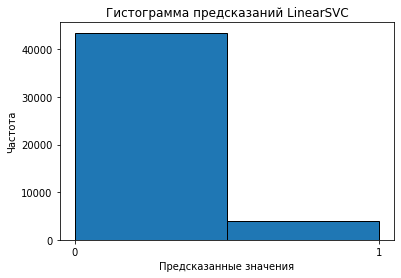

In [99]:
plt.hist(y_pred_lsvc, bins=2, edgecolor='black')
plt.title('Гистограмма предсказаний LinearSVC')
plt.xlabel('Предсказанные значения')
plt.ylabel('Частота')
plt.xticks([0, 1])
plt.show()

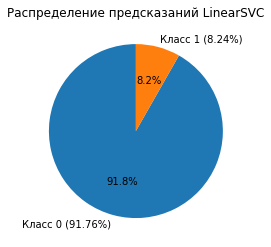

In [100]:
unique, counts = np.unique(y_pred_lsvc, return_counts=True)
total = sum(counts)
percentages = [(count / total) * 100 for count in counts]
labels = [f'Класс {label} ({percentage:.2f}%)' for label, percentage in zip(unique, percentages)]
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Распределение предсказаний LinearSVC')
plt.show()

<b>Вывод:</b>
- В ходе анализа и сравнения различных моделей, LinearSVC продемонстрировал наилучшие результаты, превысив порог качества по метрике F1 (> 0.75).
- В то время как Логистическая регрессия и Случайный лес не смогли достичь требуемого уровня точности, при этом значительно увеличив время обучения.

LinearSVC является оптимальным выбором для решения данной задачи классификации, обеспечивая высокую точность при эффективном использовании ресурсов.